In [2]:
import sys
sys.path.append('../n-trees/')
sys.path.append('../utils/')
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import datasets
import loss
import models_tests
import training_loop
import utils
import fast_generator

device = torch.device('cuda')
# device = torch.device('cpu')

# Training

In [3]:
# Create the dataset
# dataset = datasets.ForestDataset(10, 2, temp=1, maxiter=10000, size=100000)

In [3]:
# torch.save(dataset, '../datasets/dataset_15_2_1e5.pt')
# dataset = torch.load('../datasets/dataset_6_1_1e5.pt')
dataset = torch.load('../datasets/dataset_10_2_1e6.pt')
# dataset = torch.load('../datasets/dataset_15_2_1e5.pt')

In [4]:
# Create the loss function
# loss_fn = loss.EntropyLoss(P_factor=20)
loss_fn = loss.ConditionalEntropyLoss(P_factor=15)

In [5]:
# Create the model
# model = models.EntropyPrecond(
#     n=dataset.n,
#     d=dataset.d,
#     model=models.MLP(dataset.n, dataset.d),
# )

# model = models.ConditionalEntropyPrecond(
#     n=dataset.n,
#     d=dataset.d,
#     model=models.ConditionalMLP(dataset.n, 
#                                 dataset.d,
#                                 dropout             = 0.10,         # Dropout probability of intermediate activations.
#                                 num_hidden          = 8,            # Number of layers in the MLP.
#                                 hidden_size         = 4096,          # Hidden layer size.
#                                 embedding_type      = 'positional', # Timestep embedding type: 'positional' for DDPM++, 'fourier' for NCSN++.
#                                 embedding_channels  = 128,          # Number of channels in the timestep embedding.    
#                                 )
# )

# model = models.ConditionalEntropyPrecond(
#     n=dataset.n,
#     d=dataset.d,
#     model =  models.ConditionalAttention(dataset.n, 
#                                         dataset.d,                                # Number of color channels at input.
#                                         dropout             = 0.10,         # Dropout probability of intermediate activations.
#                                         num_heads           = 32,            # Number of layers in the MLP.
#                                         model_dimension     = 2048,          # Hidden layer size.
#                                         num_encoder_layers  = 16,
#                                         embedding_type      = 'positional', # Timestep embedding type: 'positional' for DDPM++, 'fourier' for NCSN++.
#                                         embedding_channels  = 128,          # Number of channels in the timestep embedding.
#                                     )
# )

model = models_tests.ConditionalEntropyPrecond(
    n=dataset.n,
    d=dataset.d,
    model =  models_tests.TestingConditionalAttention(dataset.n, 
                                        dataset.d,                                # Number of color channels at input.
                                        dropout             = 0.10,         # Dropout probability of intermediate activations.
                                        num_heads           = 8,            # Number of layers in the MLP.
                                        model_dimension     = 256,          # Hidden layer size.
                                        num_encoder_layers  = 4,
                                        embedding_type      = 'positional', # Timestep embedding type: 'positional' for DDPM++, 'fourier' for NCSN++.
                                        embedding_channels  = 128,          # Number of channels in the timestep embedding.
                                    )
)

In [6]:
# Create the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.000001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.005)

In [7]:
# Train
training_loop.simple_training_loop(
    run_dir             = '../experiments/test10_attention',      # Output directory.
    dataset             = dataset,      # Options for training set.
    network             = model,        # Options for model and preconditioning.
    loss                = loss_fn,      # Options for loss function.
    optimizer           = optimizer,    # Options for optimizer.
    seed                = 0,            # Global random seed.
    batch_size          = 128,          # Total batch size for one training iteration.
    num_workers         = 16,           # Number of data loading workers.
    total_kimg          = 2000000,      # Training duration, measured in thousands of training images.
    device              = device,
    kimg_per_tick       = 1000,          # How often to save the training state.
)

Loading dataset...


/home/trevor/miniconda3/envs/ntrees/lib/python3.11/site-packages/torch/utils/data/sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


Constructing network...
Setting up optimizer...
Setting up logs...
Training for 2000000 kimg...

tick 7813, loss 1.5796, std 9.3178, time 993.99 sec
tick 15626, loss 0.9127, std 6.8754, time 998.25 sec
tick 23439, loss 0.8151, std 6.4380, time 994.52 sec
tick 31252, loss 0.7496, std 6.0079, time 997.15 sec
tick 39065, loss 0.7037, std 5.7302, time 999.43 sec
tick 46878, loss 0.6635, std 5.4362, time 998.37 sec
tick 54691, loss 0.6340, std 5.2571, time 992.59 sec
tick 62504, loss 0.6070, std 5.0822, time 996.50 sec
tick 70317, loss 0.5851, std 4.9142, time 992.26 sec


KeyboardInterrupt: 

# Inference

In [5]:
# model = torch.load('../experiments/test01/training-state-100000.pt')['net'].to(device).eval()
# model = torch.load('../experiments/test05/training-state-100000.pt')['net'].to(device).eval()
model = torch.load('../experiments/test12_attention/training-state-300000.pt')['net'].to(device).eval()

In [6]:
test_dataset = datasets.ForestDataset(10, 2, 1, 10000, 100)
# test_dataset = datasets.ForestDataset(6, 1, 1, 10000, 100)

100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


In [29]:
data, prior = test_dataset[0]
data = data.to(device).to(torch.float32).reshape(1, data.shape[0], data.shape[1])
prior = prior.to(device).to(torch.float32).reshape(1, prior.shape[0], prior.shape[1], prior.shape[2])

rnd_normal = torch.randn([data.shape[0],1,1], device=data.device) * 1
p = rnd_normal.exp()
p = (p / 20).clamp(0, 1) / 2 # clamp flip probability to [0,0.5]

# beta = torch.distributions.beta.Beta(1.3, 4)
# p = beta.sample([data.shape[0],1,1]).to(data.device) / 2


weight = 1 / (2 * p) # weight for loss function for balancing preconditioning loss potentially not needed
y = data
n = torch.bernoulli(torch.ones_like(y) * (1 - p)) * 2 - 1 # noise equal to a bit flip occuring with probability p
n = n.to(torch.float32)
D_yn = model(y * n, prior, p)


print(p)

tensor([[[0.0202]]], device='cuda:0')


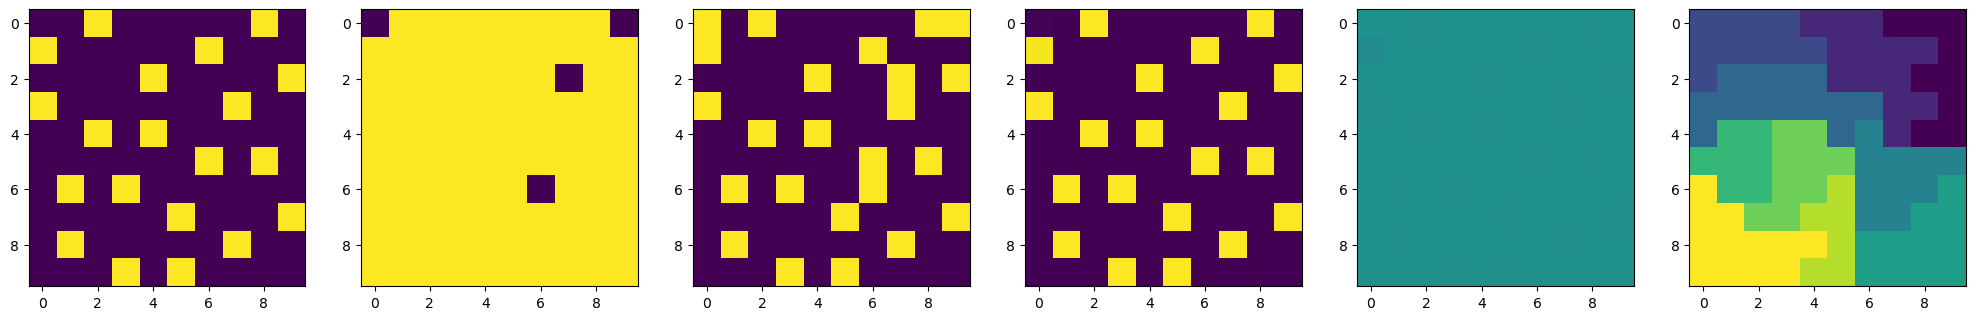

In [30]:
fig, ax = plt.subplots(1, 6, figsize=(25, 5))

ax[0].imshow(data[0].cpu().numpy())
ax[1].imshow(n[0].cpu().numpy())
ax[2].imshow((y * n)[0].cpu().numpy())
ax[3].imshow(D_yn[0].detach().cpu().numpy())
ax[4].imshow((D_yn[0].detach()-data[0]).cpu().numpy(), vmin=-0.5, vmax=0.5)
ax[5].imshow((torch.argmax(prior[0], dim=0).detach()).abs().cpu().numpy())

In [31]:
def entropic_sampler(net, latents, priors=None, num_steps=100, churn = 1, p_min = 0.001, rho=4):
    
    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=latents.device)
    t_steps = (0.5 ** (1 / rho) + step_indices / (num_steps - 1) * (p_min ** (1 / rho) - 0.5 ** (1 / rho))) ** rho
    t_steps = torch.cat([torch.as_tensor(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0
    
    if priors is not None:
        priors = priors.to(torch.float64).to(latents.device)
    
    x_next = latents.to(torch.float64)
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
        x_cur = x_next

        if churn > 0: # Removal of churn reduces this to Euler-Maruyama, a churn of 1 is approximately 1% noising at each step
            gamma = churn / num_steps if p_min <= t_cur <= 0.5 else 0
            t_hat = torch.as_tensor(t_cur + gamma * t_cur)
            p_churn = torch.bernoulli(torch.ones_like(latents) * (t_hat - t_cur)) * 2 - 1 # here probabilities follow a simple sum
            x_hat = x_cur * p_churn
        else:
            t_hat = t_cur
            x_hat = x_cur
            

        # Euler step.
        if priors is not None:
            denoised = net(x_hat, priors, t_hat).to(torch.float64)
        else:
            denoised = net(x_hat, t_hat).to(torch.float64)
        n = torch.bernoulli(((denoised * x_hat * (t_next - 1)) + 1) / 2) * 2 - 1 # flip probability computed with product
        x_next = x_hat * n

        yield utils.EasyDict(x=x_next, denoised=denoised)
    # return x_next

In [32]:
# d = 6
d = 10
latents = torch.bernoulli(torch.ones((1,d,d), device=device) * 0.5) * 2 - 1


In [68]:
prior = test_dataset[15][1].unsqueeze(0)

In [75]:
sampler = entropic_sampler(model, latents, priors=prior, num_steps=500, churn = 0.01, p_min = 0.0001, rho=4)

In [76]:
# plt.imshow(next(sampler).denoised.detach().cpu().numpy()[0])

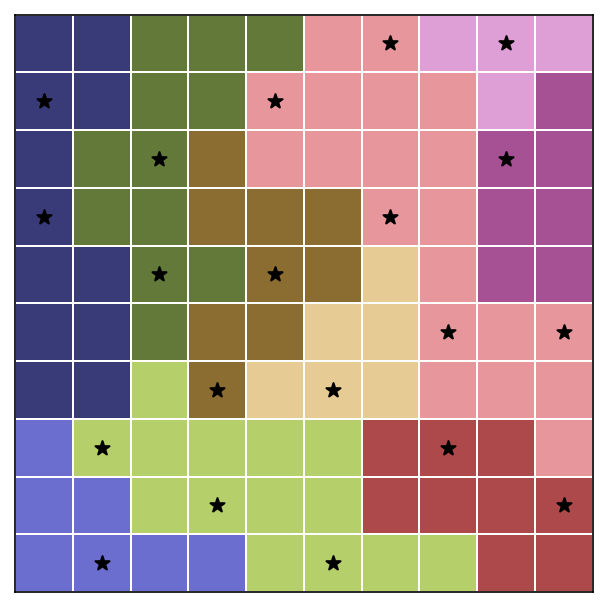

In [77]:
for i in range(500):
    forest = np.stack((((next(sampler).denoised.detach().cpu().numpy()[0]+1.3)/2).astype(np.int64), (torch.argmax(prior[0], dim=0).detach()).abs().cpu().numpy()))
fast_generator.plot_forest(forest)

In [ ]:
# p sample weighting, log-normal
rnd_normal = torch.randn([100000]) * 1.2
p = rnd_normal.exp()
p = (p / 20).clamp(0, 1)
plt.hist(p, bins=500)
plt.show()

In [ ]:
beta = torch.distributions.beta.Beta(1.5, 10)
p = beta.sample([100000])
plt.hist(p, bins=500)
plt.show()

In [ ]:
p